# <center>Lesson 7: Advanced data containers</center>
### <center>yt user/developer workshop, July 2025</center>

# Covered in this lesson:
- what are derived quantities?
- why do we need them?
- how to compute them?
- how to write your own derived quantities?

## Previous concepts:
* **field**: an array of values describing a quantity associated with each element in the `dataset`. This is the data we want. Examples: the gas densities of the grid cells, the positions of the particles, the brightness of the pixels.
* **data container**: an object containing one or more elements of a `dataset`. It provides access to `fields` for all the elements it contains.

In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ds = yt.load_sample("output_00080")

# This could be taken from a file, or calculated. For this tutorial, let's assume those
center = ds.arr([0.752022, 0.76841606, 0.7971783], "unitary")
Rvir = ds.quan(161, "kpc")
sp = ds.sphere(center, 4 * Rvir)

yt : [INFO     ] 2025-07-13 18:35:28,832 Sample dataset found in '/home/cphyc/Documents/prog/yt-data/output_00080/info_00080.txt'
yt : [INFO     ] 2025-07-13 18:35:29,382 Parameters: current_time              = 11.925285011256845 Gyr
yt : [INFO     ] 2025-07-13 18:35:29,382 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-07-13 18:35:29,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-13 18:35:29,383 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-13 18:35:29,384 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-07-13 18:35:29,384 Parameters: current_redshift          = 0.14255728632206321
yt : [INFO     ] 2025-07-13 18:35:29,385 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-07-13 18:35:29,385 Parameters: omega_matter              = 0.276000022888184
yt : [INFO     ] 2025-07-13 18:35:29,385 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

In [26]:
# Alternatively, this is a larger and more interesting dataset
ds = yt.load("../../../output_00239")
*center, Rvir = np.loadtxt("../../../output_00239/halo_qties.txt", delimiter=",")
center = ds.arr(center, "code_length")
Rvir = ds.quan(Rvir, "unitary")
sp = ds.sphere(center, 4 * Rvir)

yt : [INFO     ] 2025-07-13 18:41:43,879 Parameters: current_time              = 3.35557691104037 Gyr
yt : [INFO     ] 2025-07-13 18:41:43,880 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2025-07-13 18:41:43,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-13 18:41:43,881 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-13 18:41:43,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-07-13 18:41:43,882 Parameters: current_redshift          = 1.9494281781374165
yt : [INFO     ] 2025-07-13 18:41:43,882 Parameters: omega_lambda              = 0.68419998884201
yt : [INFO     ] 2025-07-13 18:41:43,883 Parameters: omega_matter              = 0.31580001115799
yt : [INFO     ] 2025-07-13 18:41:43,883 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-07-13 18:41:43,883 Parameters: hubble_constant           = 0.6731999969482421
yt : [WARNING  ] 2025-07-13 18:41:44,635 The DM part

Let's take a gander at our data:

yt : [INFO     ] 2025-07-13 18:41:47,162 Identified   196/  352 intersecting domains (  196 through hilbert key indexing)
yt : [INFO     ] 2025-07-13 18:41:49,998 Projection completed
yt : [INFO     ] 2025-07-13 18:41:49,999 xlim = 0.498080 0.506236
yt : [INFO     ] 2025-07-13 18:41:49,999 ylim = 0.500958 0.509113
yt : [INFO     ] 2025-07-13 18:41:50,002 xlim = 0.498080 0.506236
yt : [INFO     ] 2025-07-13 18:41:50,002 ylim = 0.500958 0.509113
yt : [INFO     ] 2025-07-13 18:41:50,004 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



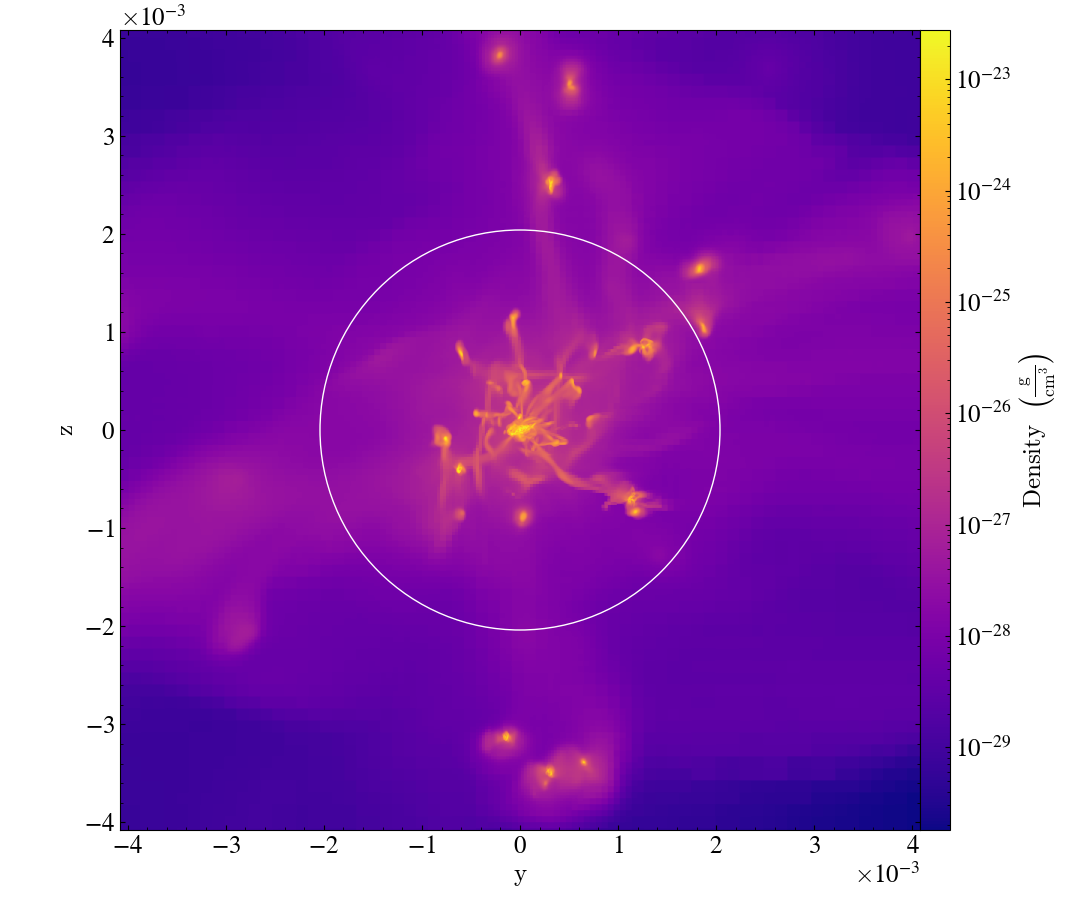

In [ ]:
p = yt.ProjectionPlot(
    ds,
    "x",
    ("gas", "density"),
    data_source=sp,
    center=sp.center,
    width=4 * Rvir,
    weight_field="density",
)
p.annotate_sphere(center, Rvir)
p

### Boolean data objects

We can combine data containers together with boolean operations. Supported operators are `&`, `|` and `~` (and, or, not). The result is a new data container that contains only the elements that match the boolean condition.

In [212]:
sp_halo = ds.sphere(center, Rvir * 2)
sp_disk = ds.sphere(center, Rvir * 0.1)

# Let's define the CGM as anything between 0.1 and 2 Rvir
sp_CGM = sp_halo - sp_disk

yt : [INFO     ] 2025-07-13 18:59:20,853 Projection completed
yt : [INFO     ] 2025-07-13 18:59:20,854 xlim = 0.498080 0.506236
yt : [INFO     ] 2025-07-13 18:59:20,855 ylim = 0.500958 0.509113
yt : [INFO     ] 2025-07-13 18:59:20,857 xlim = 0.498080 0.506236
yt : [INFO     ] 2025-07-13 18:59:20,857 ylim = 0.500958 0.509113
yt : [INFO     ] 2025-07-13 18:59:20,858 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



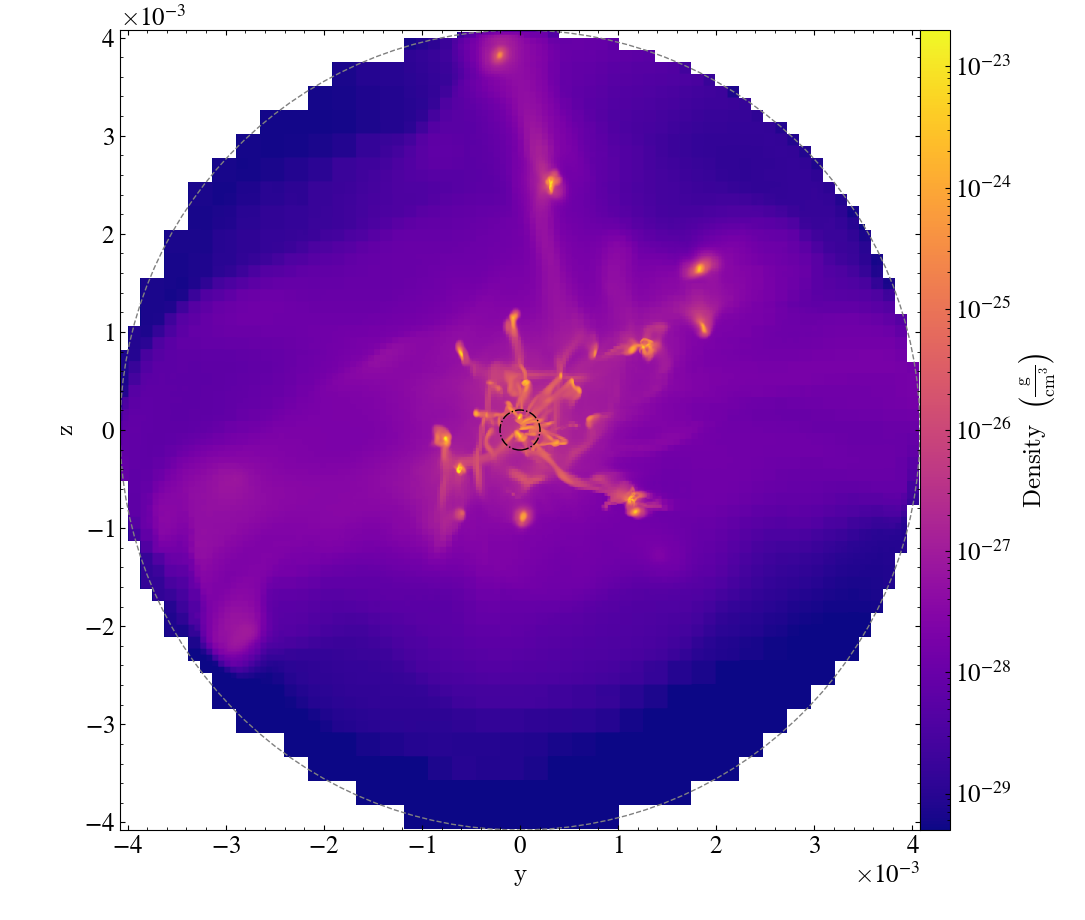

In [ ]:
p = yt.ProjectionPlot(
    ds,
    "x",
    ("gas", "density"),
    data_source=sp_CGM,
    center=sp.center,
    width=4 * Rvir,
    weight_field="density",
)
p.set_zlim(("gas", "density"), 0.5e-29, 2e-23)
p.annotate_sphere(center, 2 * Rvir, circle_args={"color": "gray", "ls": "--"})
p.annotate_sphere(center, Rvir / 10, circle_args={"color": "k", "ls": "-."})
p

### Cut region

Cut regions are a more general solution to filtering mesh fields. The output of a cut region is an entirely new data object, which can be treated like any other data object to generate images, examine its values, etc.

Let's exemplify by looking into the structure of the circum-galactic medium (CGM) of the galaxy above.


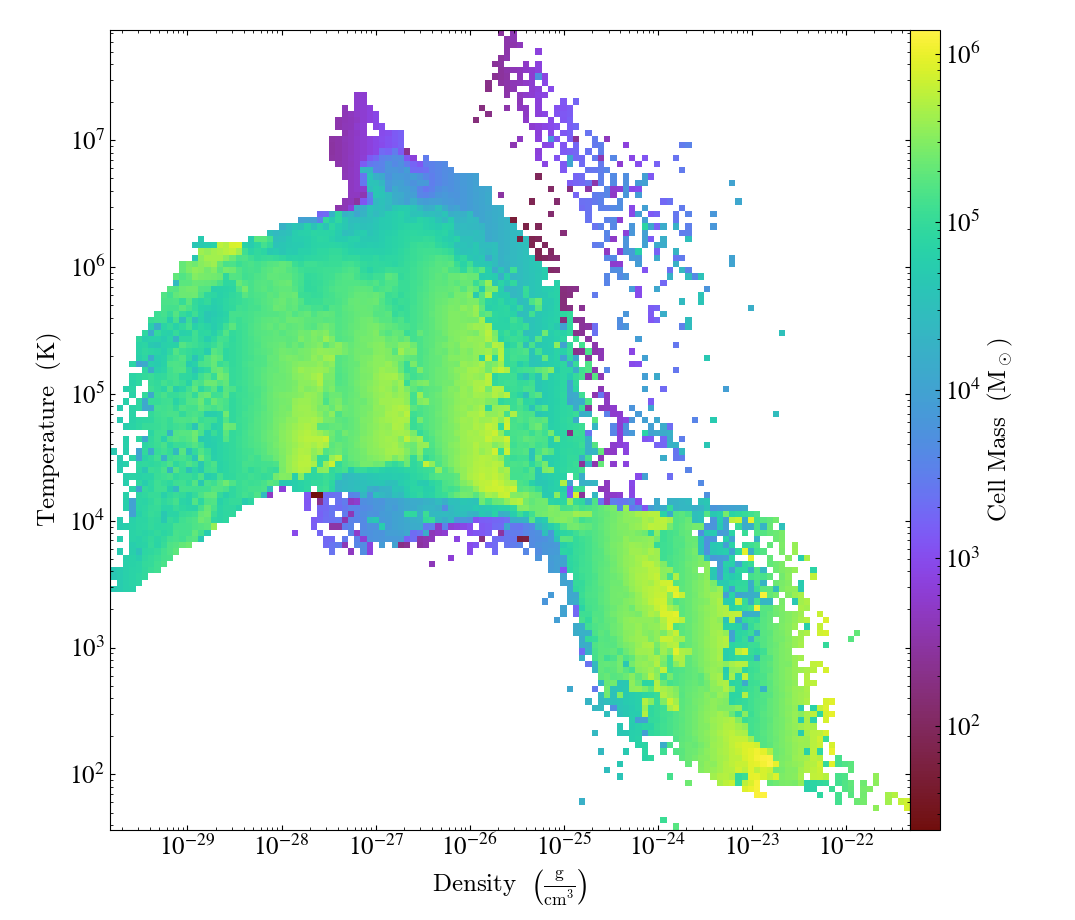

In [ ]:
pp = yt.PhasePlot(
    sp_CGM,
    "density",
    "temperature",
    "cell_mass",
)
pp.set_unit("cell_mass", "Msun")
pp.set_xunit("density", "mp/cm**3")
pp

We can create cut regions using the `include_above`, `include_below`, and `include_between` methods (or similarly `exclude_*`). Internally, these methods use the more flexible `cut_region` method.


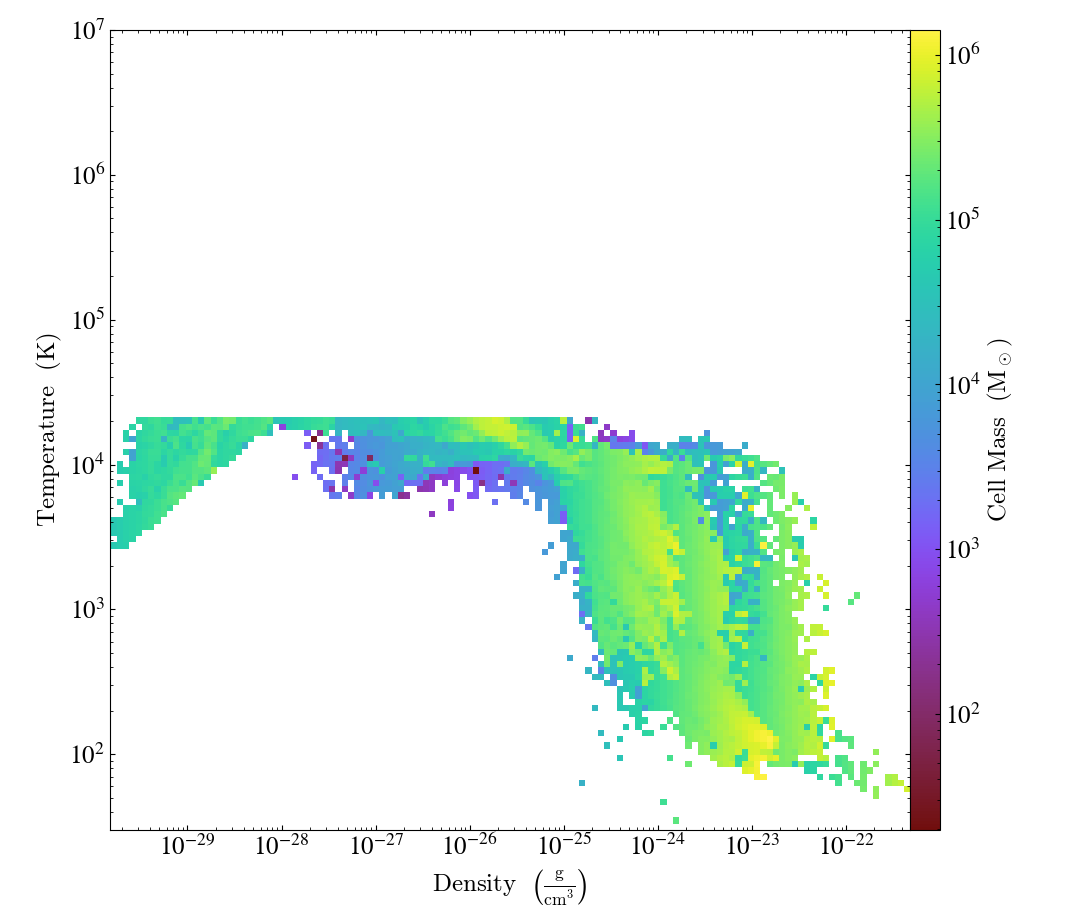

In [ ]:
sp_cold_CGM = sp_CGM.include_below("temperature", 2e4)
pp = yt.PhasePlot(
    sp_cold_CGM,
    "density",
    "temperature",
    "cell_mass",
)
pp.set_unit("cell_mass", "Msun")
pp.set_ylim(Nonek, 1e7)

yt : [INFO     ] 2025-07-13 19:00:07,463 Projection completed
yt : [INFO     ] 2025-07-13 19:00:07,463 xlim = 0.498080 0.506236
yt : [INFO     ] 2025-07-13 19:00:07,464 ylim = 0.500958 0.509113
yt : [INFO     ] 2025-07-13 19:00:07,467 xlim = 0.498080 0.506236
yt : [INFO     ] 2025-07-13 19:00:07,467 ylim = 0.500958 0.509113
yt : [INFO     ] 2025-07-13 19:00:07,469 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



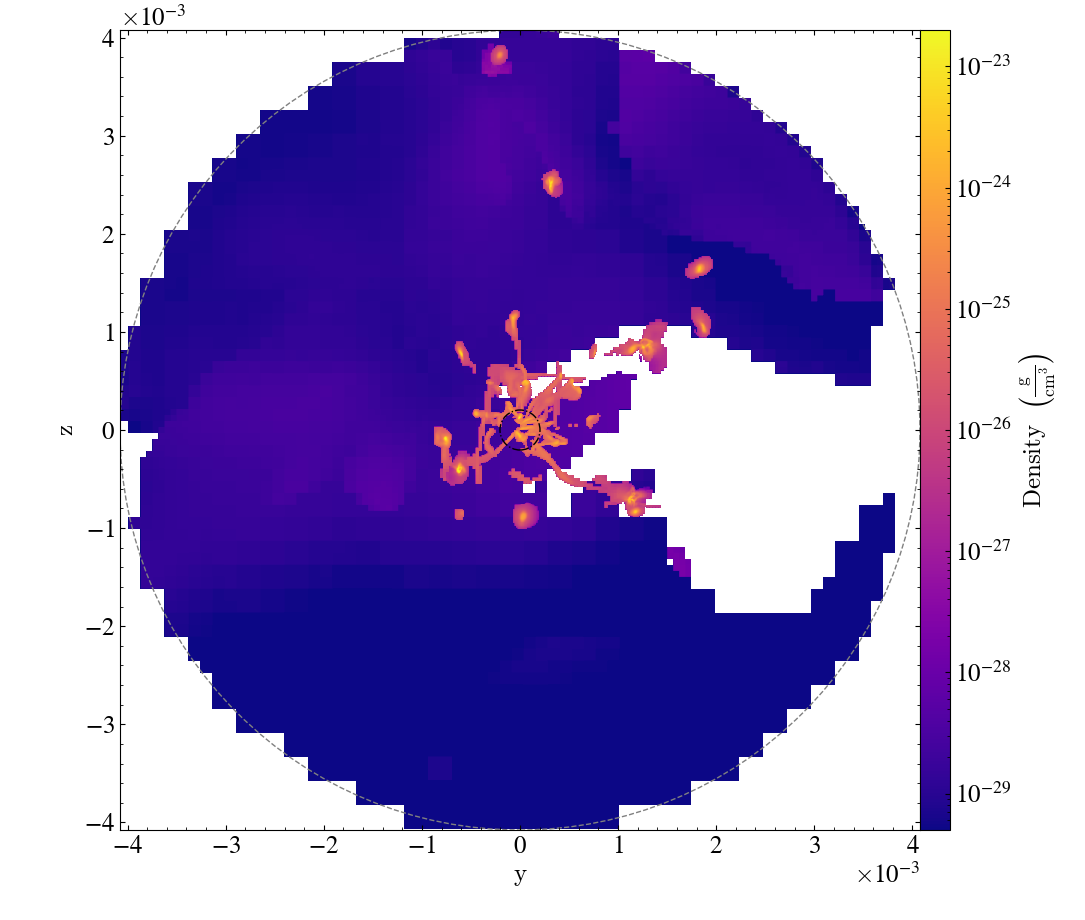

In [ ]:
p = yt.ProjectionPlot(
    ds,
    "x",
    ("gas", "density"),
    data_source=sp_cold_CGM,
    center=sp.center,
    width=4 * Rvir,
    weight_field="density",
)
p.set_zlim(("gas", "density"), 0.5e-29, 2e-23)
p.annotate_sphere(center, 2 * Rvir, circle_args={"color": "gray", "ls": "--"})
p.annotate_sphere(center, Rvir / 10, circle_args={"color": "k", "ls": "-."})
p


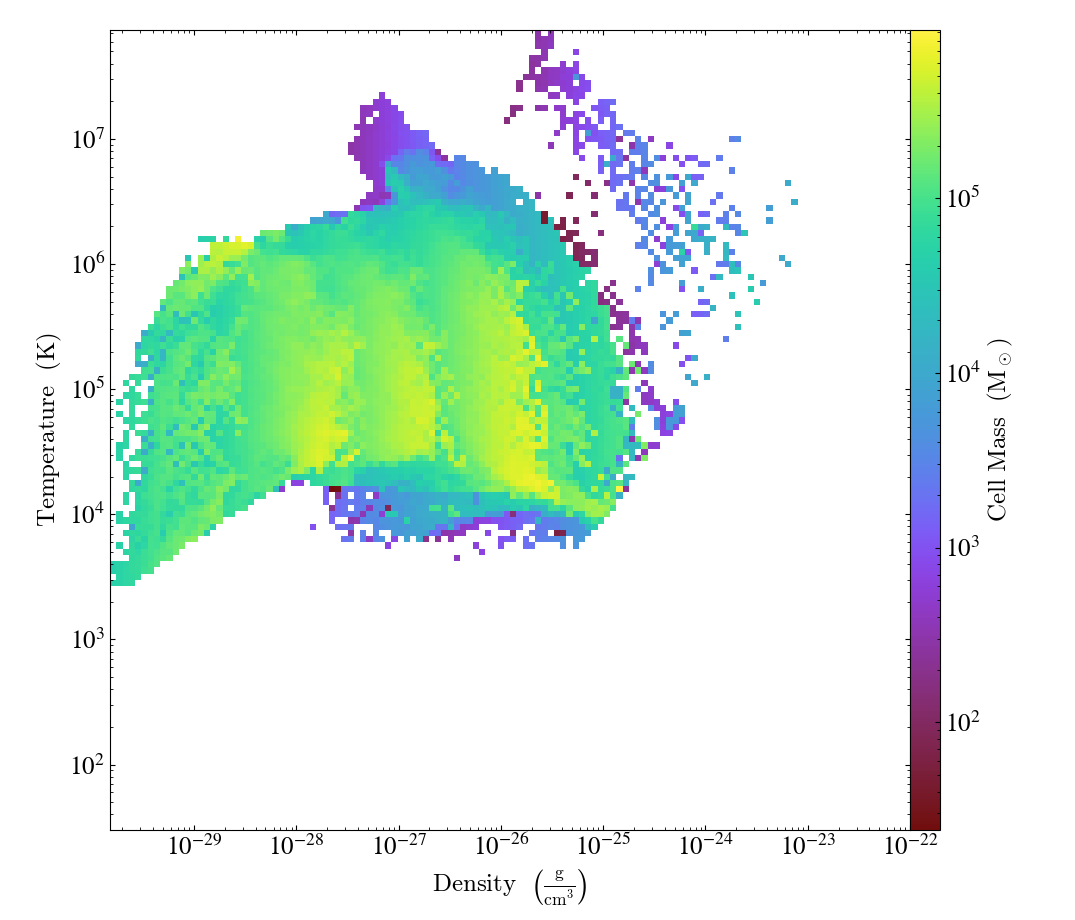

In [ ]:
sp_CGM_wo_ISM = sp_CGM.cut_region(
    ["(obj['density'] / obj['temperature']) < (1e-25 / 1e4)"]
)

pp = yt.PhasePlot(
    sp_CGM_wo_ISM,
    "density",
    "temperature",
    "cell_mass",
)
pp.set_unit("cell_mass", "Msun")
pp.set_xlim(None, 1e-22)
pp.set_ylim(30, None)

### (Iso-)Surfaces

We can extract surfaces, which yields a regular data container.

In [48]:
surf = ds.surface(sp_disk, ("gas", "density"), (1, "mp/cm**3"))

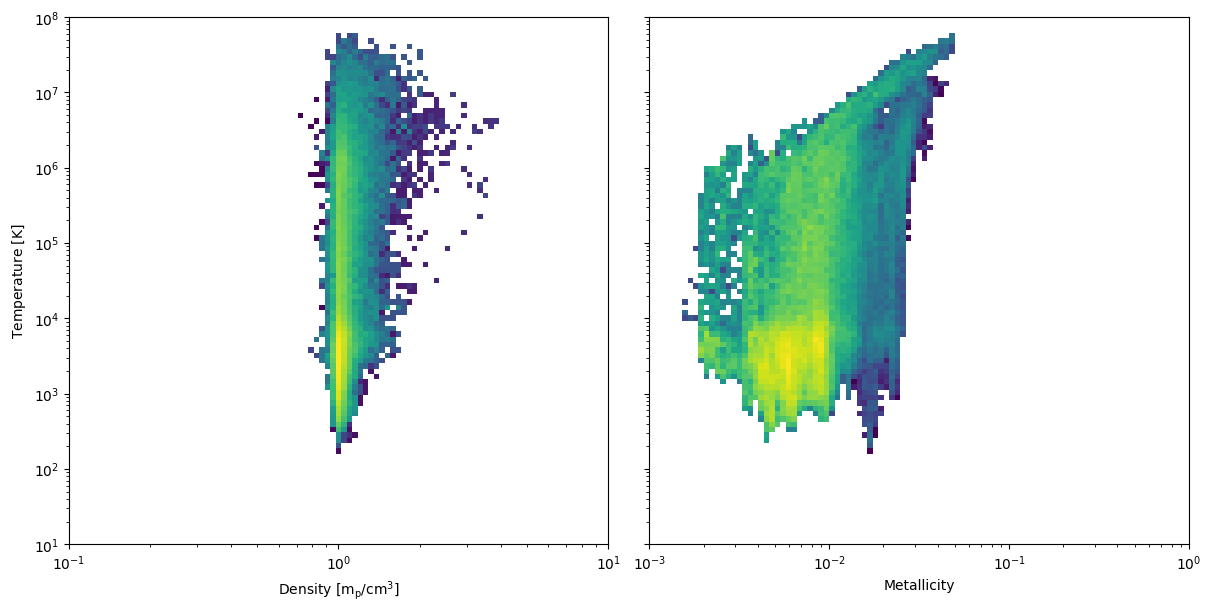

In [50]:
# Unfortunately, phase plots cannot be made with a surface data container yet.
# Let's do it manually
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, constrained_layout=True)
axes[0].hist2d(
    surf["gas", "density"].to("mp/cm**3"),
    surf["gas", "temperature"].to("K"),
    bins=(np.geomspace(1e-1, 1e1, 100), np.geomspace(1e1, 1e8, 100)),
    weights=surf["gas", "cell_mass"].to("Msun").d,
    norm=plt.matplotlib.colors.LogNorm(),
)
axes[0].set(
    xlabel=r"Density [$\mathrm{m_p/cm^3}$]",
    ylabel=r"Temperature [$\mathrm{K}$]",
    xscale="log",
    yscale="log",
)

axes[1].hist2d(
    surf["gas", "metallicity"],
    surf["gas", "temperature"].to("K"),
    bins=(np.geomspace(1e-3, 1, 100), np.geomspace(1e1, 1e8, 100)),
    weights=surf["gas", "cell_mass"].to("Msun").d,
    norm=plt.matplotlib.colors.LogNorm(),
)
axes[1].set(
    xlabel=r"Metallicity",
    xscale="log",
    yscale="log",
)
fig.align_xlabels(axes)

The surface also has a `.triangles` attribute that allow to render this in 3D. See the section on [complex plots](https://yt-project.org/doc/cookbook/complex_plots.html#plotting-isocontours) for more details.

[Text(0.5, 0, 'x [kpc]'),
 Text(0.5, 0.5, 'y [kpc]'),
 Text(0.5, 0, 'z [kpc]'),
 Text(0.5, 0.92, 'Isodensity surface colored by log10(temperature)')]

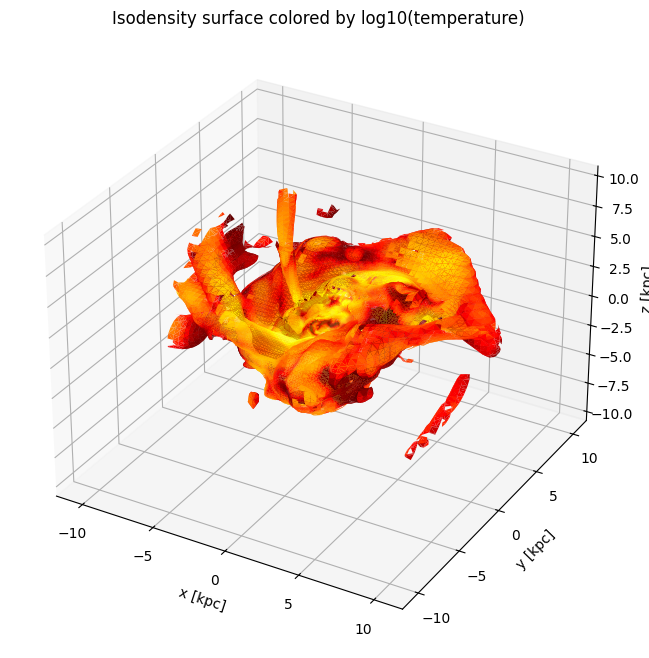

In [46]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Color this isodensity surface according to the log of the temperature field
colors = yt.apply_colormap(np.log10(surf["gas", "temperature"]), cmap_name="hot")

# Create a 3D matplotlib figure for visualizing the surface
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
p3dc = Poly3DCollection((surf.triangles - center).to("kpc"), linewidth=0.0)

# Set the surface colors in the right scaling [0,1]
p3dc.set_facecolors(colors[0, :, :] / 255.0)
ax.add_collection(p3dc)

# Let's keep the axis ratio fixed in all directions by taking the maximum
# extent in one dimension and make it the bounds in all dimensions
max_extent = (surf.vertices.max(axis=1) - surf.vertices.min(axis=1)).max()
bounds = np.zeros([3, 2])
bounds[:, 0] = -max_extent.to("kpc") / 2
bounds[:, 1] = +max_extent.to("kpc") / 2
ax.auto_scale_xyz(bounds[0, :], bounds[1, :], bounds[2, :])
ax.set(
    xlabel="x [kpc]",
    ylabel="y [kpc]",
    zlabel="z [kpc]",
    title="Isodensity surface colored by log10(temperature)",
)

### Slices, cuts and projections

While slices are often used for visualization, they can be useful for other operations as well. yt regards slices as multi-resolution objects. They are an array of cells that are not all the same size; it only returns the cells at the highest resolution that it intersects.

In [152]:
slice = ds.slice("x", center[0], data_source=sp_CGM, center=sp.center)
# Alternative syntax:
# slice = ds.r[center[0], :, :]

In [153]:
slice["density"], slice["temperature"]

yt : [INFO     ] 2025-07-13 19:32:36,369 Identified 29 intersecting domains


(unyt_array([5.19746327e-30, 5.30657486e-30, 1.44363117e-29, ...,
        8.30684549e-30, 8.46511640e-30, 8.92034102e-30], shape=(15105,), units='g/cm**3'),
 unyt_array([  4951.21334369,  12016.39942994,  17732.52881461, ...,
        276919.43499444, 273325.28567427, 263964.45630352], shape=(15105,), units='K'))

Note that slices do yields cells in the simulation, not a projection onto a regular 2D grid!

In [154]:
slice["dx"].min().to("pc"), slice["dx"].max().to("pc")

(unyt_quantity(191.7689612, 'pc'), unyt_quantity(12273.21351704, 'pc'))

Similarly, we can create an off-axis slice using `cutting` instead of `slice`.

In [155]:
cut = ds.cutting([0.1, 0.2, 0.3], center, data_source=sp_CGM)

In [156]:
cut["density"], cut["temperature"], cut["dx"].min().to("pc"), cut["dx"].max().to("pc")

yt : [INFO     ] 2025-07-13 19:32:38,817 Identified 36 intersecting domains


(unyt_array([7.32234678e-30, 1.13947536e-29, 1.18487231e-29, ...,
        1.22633273e-29, 1.33181198e-29, 1.50773463e-29], shape=(26256,), units='g/cm**3'),
 unyt_array([ 46336.33340428, 104477.74578934, 110689.82104433, ...,
         70872.7177793 ,  69694.24601899,  67055.75629497], shape=(26256,), units='K'),
 unyt_quantity(47.9422403, 'pc'),
 unyt_quantity(12273.21351704, 'pc'))

Finally, we can also create projections. Those implement a line integration along the provided direction and return a representation of the integrated field.

In [174]:
proj = ds.proj(("gas", "density"), "x", data_source=sp_CGM)
proj_wei = ds.proj(
    ("gas", "density"), "x", data_source=sp_CGM, weight_field="dx"
)
proj_std = ds.proj(
    ("gas", "density"), "x", data_source=sp_CGM, weight_field="dx", moment=2
)
proj_max = ds.proj(("gas", "density"), "x", data_source=sp_CGM, method="max")

yt : [INFO     ] 2025-07-13 19:36:38,771 Projection completed


In [175]:
(
    np.nanmax(proj["temperature"]),
    np.nanmax(proj_wei["temperature"]),
    np.nanmax(proj_std["temperature"]),
    np.nanmax(proj_max["temperature"]),
)

/home/cphyc/Documents/24-25/Conferences/yt workshop/venv/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


(unyt_quantity(1.21850549e+30, 'K*cm'),
 unyt_quantity(651787.56676071, 'K'),
 unyt_quantity(704839.55062591, 'K'),
 unyt_quantity(74233431.47176519, 'K'))

### Fixed resolution buffers (FRBs)
Very commonly, we want to project or slice a field through a specific point in space and project onto a regular 2D grid.

In [179]:
L = center - 2 * Rvir
R = center + 2 * Rvir
# Create a 1024x1024 pixel FRB centered on the center of the halo
frb = ds.r[center[0], L[1] : R[1] : 1024j, L[2] : R[2] : 1024j]

yt : [INFO     ] 2025-07-13 19:36:47,887 Making a fixed resolution buffer of (('gas', 'density')) 1024 by 1024
yt : [INFO     ] 2025-07-13 19:36:48,523 Identified 63 intersecting domains


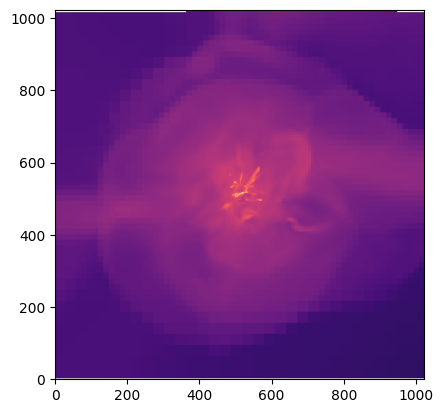

In [177]:
plt.imshow(
    frb["gas", "density"].to("mp/cm**3").d,
    origin="lower",
    cmap="magma",
    norm=plt.matplotlib.colors.LogNorm(),
)

We can also obtain a fixed resolution buffer from a slice or a projection

yt : [INFO     ] 2025-07-13 19:36:49,659 Making a fixed resolution buffer of (('gas', 'density')) 1024 by 1024


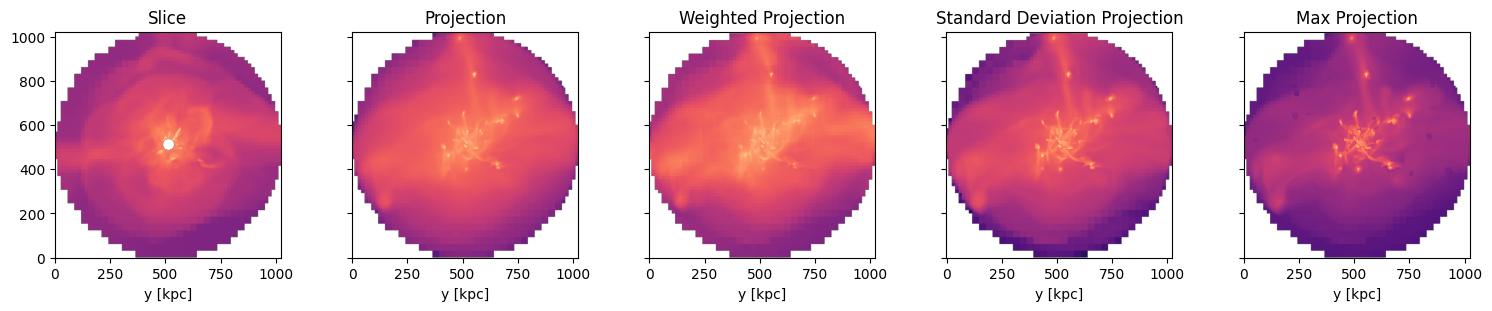

In [178]:
containers = (slice, proj, proj_wei, proj_std, proj_max)
fig, axes = plt.subplots(
    ncols=len(containers),
    figsize=(len(containers) * 3, 3),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

for ax, container, title in zip(
    axes,
    containers,
    (
        "Slice",
        "Projection",
        "Weighted Projection",
        "Standard Deviation Projection",
        "Max Projection",
    ),
):
    im = ax.imshow(
        container.to_frb(4 * Rvir, 1024, center=center)["gas", "density"].d,
        origin="lower",
        cmap="magma",
        norm=plt.matplotlib.colors.LogNorm(),
    )
    ax.set_title(title)
    ax.set_xlabel("y [kpc]")

### Arbitrary grids
This allows to project *everything* onto an arbitrary regular grid with a fixed resolution. It needs not be aligned with the simulation grid. Note that this may be expensive, as yt needs to interpolate the data onto the new grid. You can see it as the 3D equivalent of a fixed resolution buffer.

In [191]:
grid = ds.r[L[0]:R[0]:256j, L[1]:R[1]:256j, L[2]:R[2]:256j]
# or equivalently
grid = ds.arbitrary_grid(L, R, (256, 256, 256))

In [186]:
grid["gas", "density"].shape

(256, 256, 256)

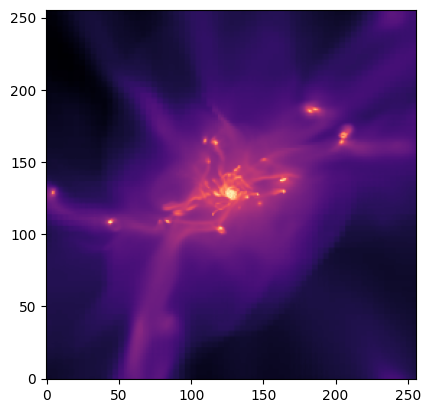

In [192]:
plt.imshow(grid["gas", "density"].sum(axis=2).T, origin="lower", cmap="magma", norm=plt.matplotlib.colors.LogNorm())

### Covering grids
As seen above, interpolating data onto an arbitrary grid can be expensive. If possible, consider using a (smooth) covering grid instead. This is similar in spirit, except the covering grid is aligned with the simulation grid and only interpolates the data onto the new grid.

In [195]:
sp_CGM["index", "grid_level"].max()

unyt_quantity(11., '(dimensionless)')

In [259]:
smoothed_grid = ds.smoothed_covering_grid(level=6, left_edge=L, dims=(256, 256, 256), num_ghost_zones=1)
grid = ds.covering_grid(level=6, left_edge=L, dims=(256, 256, 256))

In [260]:
grid["gas", "density"].shape

yt : [INFO     ] 2025-07-13 20:07:20,845 Identified    82/  352 intersecting domains (  182 through hilbert key indexing)


(256, 256, 256)

yt : [INFO     ] 2025-07-13 20:07:22,085 Identified    65/  352 intersecting domains (  182 through hilbert key indexing)
yt : [INFO     ] 2025-07-13 20:07:22,200 Identified    51/  352 intersecting domains (  182 through hilbert key indexing)
yt : [INFO     ] 2025-07-13 20:07:22,266 Identified    37/  352 intersecting domains (  182 through hilbert key indexing)
yt : [INFO     ] 2025-07-13 20:07:22,460 Identified    51/  352 intersecting domains (  182 through hilbert key indexing)
yt : [INFO     ] 2025-07-13 20:07:22,748 Identified    64/  352 intersecting domains (  182 through hilbert key indexing)
yt : [INFO     ] 2025-07-13 20:07:23,508 Identified    81/  352 intersecting domains (  182 through hilbert key indexing)


Text(0.5, 1.0, 'Smoothed covering grid')

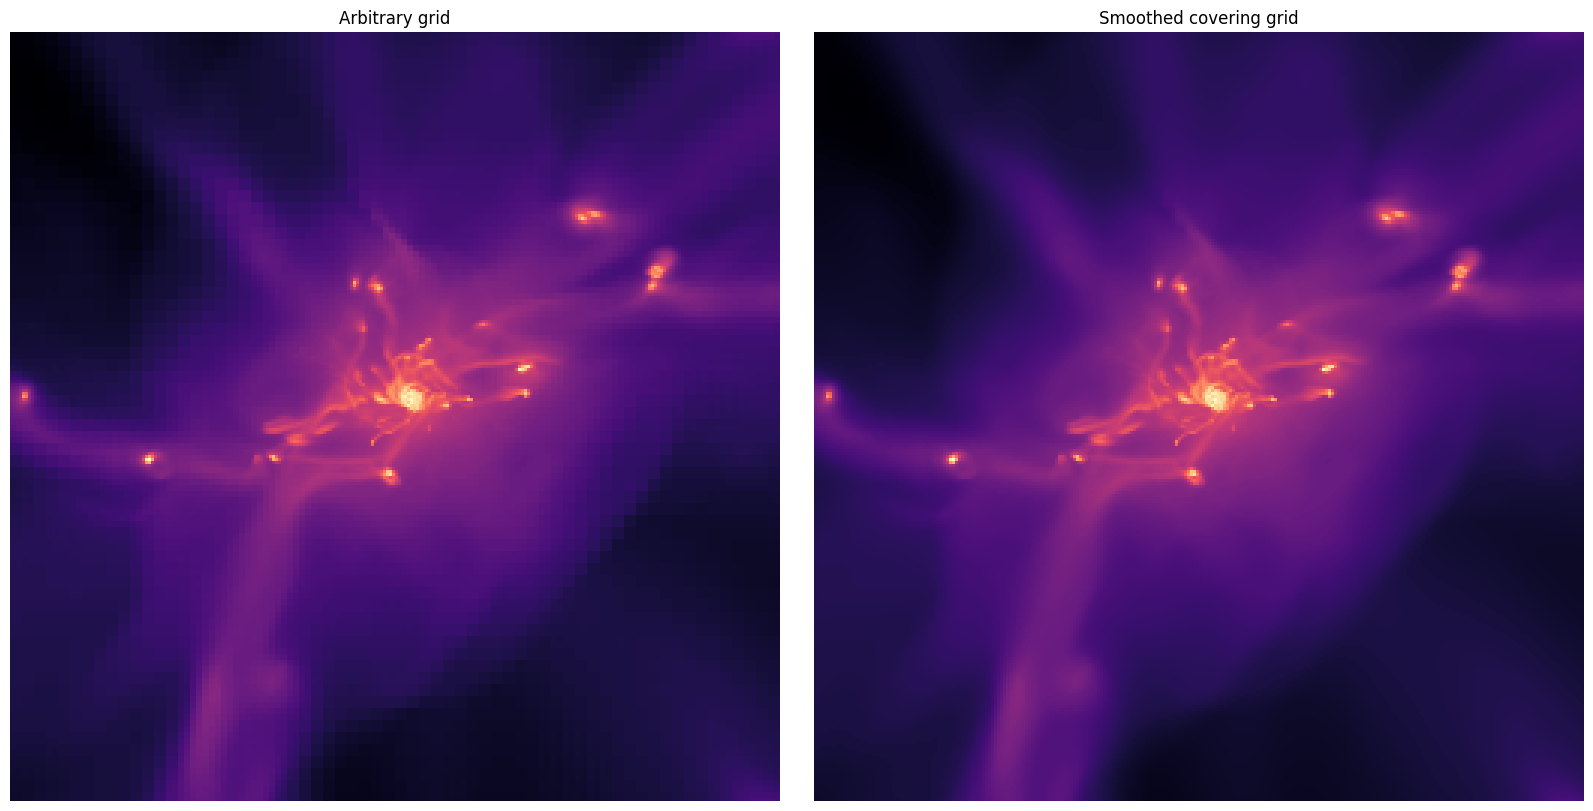

In [261]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), constrained_layout=True)
for ax in axes:
    ax.axis("off")

kwa = {"origin": "lower", "cmap": "magma", "norm": plt.matplotlib.colors.LogNorm()}
axes[0].imshow(grid["gas", "density"].sum(axis=2).T, **kwa)
axes[1].imshow(smoothed_grid["gas", "density"].sum(axis=2).T, **kwa)
axes[0].set_title("Arbitrary grid")
axes[1].set_title("Smoothed covering grid")

Having a uniform grid can be useful, for example to compute the power spectrum or to compute finite differences that are more easily expressed on a uniform grid.

In [283]:
# Compute the velocity dispersion in cubes of size [3x3x3] pixels
vtot = np.zeros((*smoothed_grid["velocity_x"].shape, 3))

for i in range(3):
    for j in range(3):
        for k in range(3):
            vtot[..., 0] += np.roll(smoothed_grid["velocity_x"].d, (i-1, j-1, k-1))
            vtot[..., 1] += np.roll(smoothed_grid["velocity_y"].d, (i-1, j-1, k-1))
            vtot[..., 2] += np.roll(smoothed_grid["velocity_z"].d, (i-1, j-1, k-1))
vtot /= 27

vvar = np.zeros(smoothed_grid["velocity_x"].shape)
for i in range(3):
    for j in range(3):
        for k in range(3):
            vvar += (np.roll(smoothed_grid["velocity_x"].d, (i-1, j-1, k-1)) - vtot[..., 0]) ** 2
            vvar += (np.roll(smoothed_grid["velocity_y"].d, (i-1, j-1, k-1)) - vtot[..., 1]) ** 2
            vvar += (np.roll(smoothed_grid["velocity_z"].d, (i-1, j-1, k-1)) - vtot[..., 2]) ** 2
vvar = ds.arr(vvar / 27, smoothed_grid["velocity_x"].units**2)

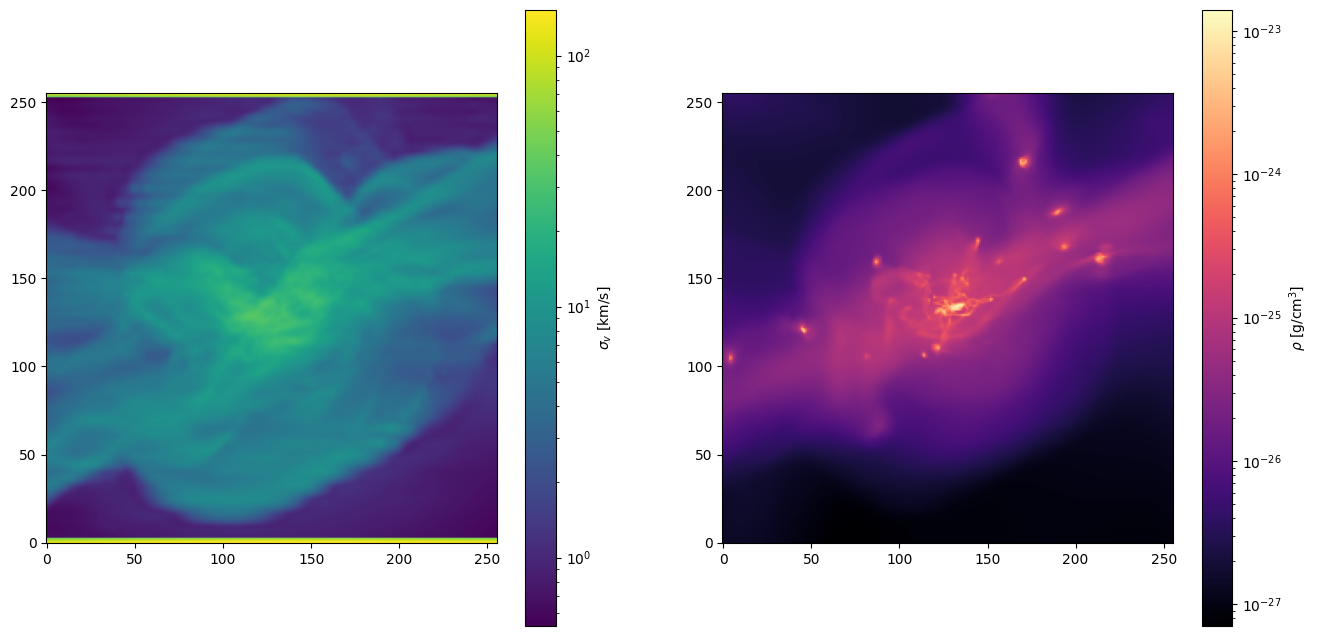

In [289]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
IM = axes[0].imshow(np.sqrt(vvar).to("km/s").mean(axis=1).T, origin="lower", cmap="viridis", norm=plt.matplotlib.colors.LogNorm())
CB = plt.colorbar(IM, ax=axes[0])
CB.set_label(r"$\sigma_v$ [km/s]")

IM = axes[1].imshow(smoothed_grid["gas", "density"].sum(axis=1).T, origin="lower", cmap="magma", norm=plt.matplotlib.colors.LogNorm())
CB = plt.colorbar(IM, ax=axes[1])
CB.set_label(r"$\rho$ [g/cm$^3$]")

### Streamlines
Unfortunately doesn't work for oct datasets yet.

In [ ]:
from yt.visualization.api import Streamlines

# Load the dataset
ds = yt.load_sample("IsolatedGalaxy")

# Define c: the center of the box, N: the number of streamlines,
# scale: the spatial scale of the streamlines relative to the boxsize,
# and then pos: the random positions of the streamlines.
c = ds.domain_center
N = 100
scale = ds.domain_width[0]
pos_dx = np.random.random((N, 3)) * scale - scale / 2.0
pos = c + pos_dx

# Create streamlines of the 3D vector velocity and integrate them through
# the box defined above
streamlines = Streamlines(
    ds,
    pos,
    ("gas", "velocity_x"),
    ("gas", "velocity_y"),
    ("gas", "velocity_z"),
    length=1.0 * Mpc,
    get_magnitude=True,
)
streamlines.integrate_through_volume()

yt : [INFO     ] 2025-07-13 20:27:48,727 'IsolatedGalaxy' is not available locally. Looking up online.
yt : [INFO     ] 2025-07-13 20:27:48,729 Downloading from https://yt-project.org/data/IsolatedGalaxy.tar.gz
